# Using RNNs/Lstms - Varying Length

In this notebook, we will implement an RNN model on the data of varying length, evaluate and analyze the output. 

In [2]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import  Dense, Embedding, LSTM, Bidirectional
from keras.layers import Dropout
from keras.layers.core import Dense
import seaborn as sns
from keras.layers.core import Dropout
from keras.layers.core import Activation
from keras.layers.core import Flatten
import scipy.stats as stats
from sklearn import preprocessing

from keras.preprocessing import sequence
from tensorflow.keras.optimizers import Adam
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.convolutional import Conv1D
from sklearn import preprocessing


## 1. We read the preprocessed data. 

In [59]:
#We load the data
data_path = "Data/GSM4084997_varying_length_PREPROCESSED.csv.gz"
df = pd.read_csv(data_path, compression='gzip')

## 2. We split the data in training, validation and testing set.

### For dividing our dataset into training and validation set, we will follow the procesure seen in the paper which consists in taking the top 100 UTRs with most sequencing reads at each length from 25 to 100nt as the test set.

In [134]:
df["one-hot encoding"] = df["one-hot encoding"].apply(ast.literal_eval)
df["one-hot encoding"]

0         [[0, 1, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0,...
1         [[0, 1, 0, 0], [0, 0, 0, 1], [1, 0, 0, 0], [0,...
2         [[0, 1, 0, 0], [0, 1, 0, 0], [1, 0, 0, 0], [0,...
3         [[0, 0, 0, 1], [1, 0, 0, 0], [0, 1, 0, 0], [0,...
4         [[0, 0, 0, 1], [0, 1, 0, 0], [0, 1, 0, 0], [1,...
                                ...                        
101721    [[0, 0, 0, 1], [0, 0, 1, 0], [0, 0, 1, 0], [0,...
101722    [[1, 0, 0, 0], [0, 0, 0, 1], [0, 0, 0, 1], [0,...
101723    [[0, 0, 1, 0], [0, 0, 0, 1], [0, 0, 0, 1], [1,...
101724    [[1, 0, 0, 0], [0, 0, 1, 0], [0, 0, 1, 0], [0,...
101725    [[0, 0, 1, 0], [0, 0, 1, 0], [0, 0, 1, 0], [0,...
Name: one-hot encoding, Length: 101726, dtype: object

In [135]:
#We follow the same procedure as in the paper (this cell follows similar code than in the paper)
df_test = pd.DataFrame(columns=df.columns)
for i in range(25,101):
    if (i in df["len"].values):
        df_len = df[df['len']== i]
        df_len = df_len.sort_values('total_reads', ascending=False)
        df_len.reset_index(inplace=True, drop=True)
        df_test = df_test.append(df_len.iloc[:100])

In [136]:
#We use the other rows as training set
df_test_indices = df_test.index
df_train_indices = set(df.index) ^ set(df_test_indices)
print(len(df_train_indices))
print(len(df_test_indices))
print(len(df))

101626
7600
101726


In [137]:
df_train = df.loc[df_train_indices]
df_train.head()

,Unnamed: 0,utr,set,0,1,2,3,4,5,6,...,r8,r9,r10,r11,r12,total,rl,len,one-hot encoding,scaled_rl
100,84339,CCCAAACAATGACCATCTGACTCCGGTCAAGTT,random,251,306,327,299,313,199,81,...,0.039507,0.043015,0.047276,0.051164,0.132952,0.001017,4.146183,33,"[[0, 1, 0, 0], [0, 1, 0, 0], [0, 1, 0, 0], [1,...",-0.858599
101,9045,CCATATTTGAGTAAGCCACTCACATT,random,154,154,113,97,267,323,211,...,0.083512,0.083486,0.074304,0.078345,0.058800,0.000933,5.788789,26,"[[0, 1, 0, 0], [0, 1, 0, 0], [1, 0, 0, 0], [0,...",0.371124
102,75027,CATACCATATGCAAAGTCTATCTTG,random,188,162,198,204,345,309,142,...,0.056654,0.060465,0.068254,0.076314,0.092855,0.000970,5.137631,25,"[[0, 1, 0, 0], [1, 0, 0, 0], [0, 0, 0, 1], [1,...",-0.116360
103,92334,GCAAACCAAACTCACTACCCCTGACACC,human,172,107,86,76,172,260,185,...,0.112399,0.098983,0.092389,0.089096,0.047820,0.000895,6.232782,28,"[[0, 0, 1, 0], [0, 1, 0, 0], [1, 0, 0, 0], [1,...",0.703515
104,62996,GGAATGGCCTGCTTCGACTGTTCTT,random,437,876,528,272,125,76,37,...,0.023734,0.028215,0.038460,0.030416,0.053246,0.001079,2.816402,25,"[[0, 0, 1, 0], [0, 0, 1, 0], [1, 0, 0, 0], [1,...",-1.854128


In [139]:
X_train = df_train["one-hot encoding"]
X_train.shape

(101626,)

In [141]:
X_train = np.array([np.array(x) for x in X_train])
X_train.shape

(101626, 100, 4)

In [142]:
#Sanity check 
print("X_train shape: {}".format(X_train.shape))

X_train shape: (101626, 100, 4)


In [164]:
y_train = df_train["rl"]
y_train

100       4.146183
101       5.788789
102       5.137631
103       6.232782
104       2.816402
            ...   
101721    2.240598
101722    6.582539
101723    4.505939
101724    5.441128
101725    3.259813
Name: rl, Length: 101626, dtype: float64

## 3. We build our model and train it using our datasets.

In [165]:
batch_size = 128
input_dim = 100
input_dim2 = 4
units = 75

def train_lstm_model(x, y, border_mode='same', inp_len=100, nodes=40,
                dropout1=0.2, dropout2=0.2, dropout3=0.2, nb_epoch=3):
    """This function build our model and fits it."""
    model = Sequential()
    model.add(LSTM(units=75, input_shape=(100, 4), return_sequences=True))
    model.add(LSTM(units=75, input_shape=(100, 4), return_sequences=True))
    model.add(Dropout(dropout2))
    model.add(LSTM(units=75, input_shape=(100, 4), return_sequences=True))

    model.add(Dropout(dropout2))
    model.add(Flatten())

    model.add(Dense(nodes))
    model.add(Activation('relu'))
    model.add(Dropout(dropout3))
    
    model.add(Dense(1))
    model.add(Activation('linear'))

    #compile the model
    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='mean_squared_error', optimizer=adam)
    model.fit(x, y, batch_size=128, epochs=nb_epoch, verbose=1)
    return model

In [166]:
def r2(x,y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    return r_value**2

In [167]:
model = train_lstm_model(X_train, y_train, nb_epoch=5)

/Users/mariehuynh/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/5
794/794 [==============================] - 217s 268ms/step - loss: 2.3486
Epoch 2/5
794/794 [==============================] - 200s 252ms/step - loss: 1.9877
Epoch 3/5
794/794 [==============================] - 241s 303ms/step - loss: 1.4311
Epoch 4/5
794/794 [==============================] - 246s 310ms/step - loss: 1.2578
Epoch 5/5
794/794 [==============================] - 469s 590ms/step - loss: 1.1896


In [168]:
X_test = df_test["one-hot encoding"]
X_test = np.array([np.array(x) for x in X_test])

In [169]:
preds = model.predict(X_test).reshape(-1)
preds

array([4.862675 , 5.79163  , 5.5970836, ..., 6.273632 , 2.2081926,
       5.3504477], dtype=float32)

In [170]:
df_test["pred rl"] = preds.tolist()
df_test["pred rl"]

0     4.862675
1     5.791630
2     5.597084
3     4.476732
4     5.221886
        ...   
95    6.501698
96    4.814098
97    6.273632
98    2.208193
99    5.350448
Name: pred rl, Length: 7600, dtype: float64

In [171]:
df_test["rl"]

0     4.300281
1     5.645849
2     5.668048
3     3.515382
4     4.579015
        ...   
95    7.149246
96    5.434171
97    7.468888
98    6.175621
99    6.285791
Name: rl, Length: 7600, dtype: float64

In [172]:
r = r2(df_test["rl"], df_test["pred rl"])
print('r-squared = ', r)

r-squared =  0.6178245373234419


In [198]:
from sklearn.metrics import r2_score
r2_score(df_test["rl"], df_test["pred rl"])

0.6058613039534126

In [176]:
model.save('./saved_models/3_lstms_varying_length.hdf5')

## 4. We analyze the output

In [227]:
model = keras.models.load_model('./saved_models/3_lstms_varying_length.hdf5')

/Users/mariehuynh/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


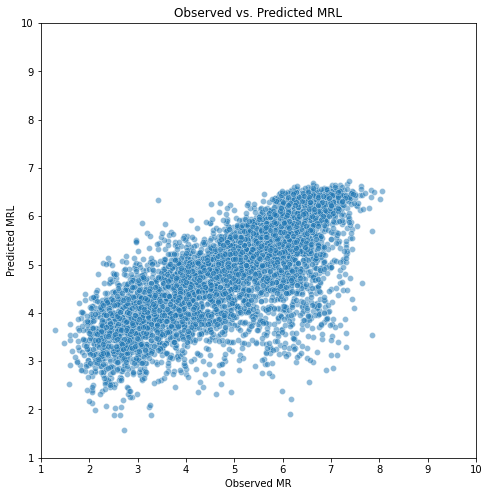

In [173]:
fig = plt.figure(figsize = (8,8))
sns.scatterplot(df_test['rl'], df_test["pred rl"],linewidth = 0.5, alpha=0.5)
plt.xlabel('Observed MR')
plt.ylabel('Predicted MRL') 
plt.xlim(1, 10)
plt.ylim(1, 10)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.title('Observed vs. Predicted MRL')
plt.show()

In [174]:
df_test_atg = df_test[df_test['utr'].apply(lambda x: 'ATG' in x)]
df_test_no_atg = df_test[df_test['utr'].apply(lambda x: 'ATG' not in x)]

/Users/mariehuynh/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/mariehuynh/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


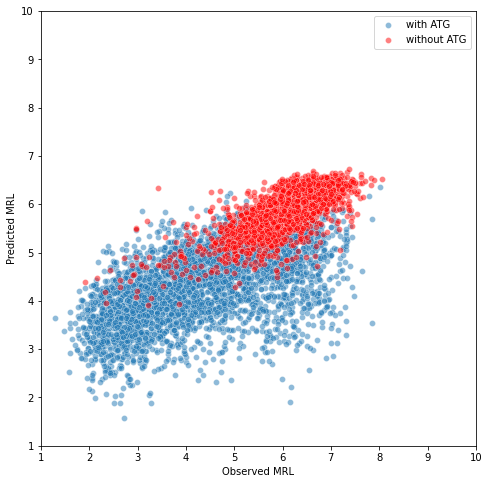

In [175]:
fig = plt.figure(figsize = (8,8))
sns.scatterplot(df_test_atg["rl"], df_test_atg["pred rl"],linewidth = 0.5, alpha=0.5, label = 'with ATG')
ax = sns.scatterplot(df_test_no_atg["rl"], df_test_no_atg["pred rl"],
                 linewidth = 0.5, alpha=0.5, label = 'without ATG', color = 'r', legend = 'auto')
plt.xlim(1, 10)
plt.ylim(1, 10)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
ax.set(xlabel = 'Observed MRL', ylabel = 'Predicted MRL')
plt.show()

## Analysis of the output

In [177]:
df_test["rl class"] = df_test["rl"].apply(round)
df_test["pred rl class"] = df_test["pred rl"].apply(round)
df_test["pred rl class"]
df_test["rl class"]

0     4
1     6
2     6
3     4
4     5
     ..
95    7
96    5
97    7
98    6
99    6
Name: rl class, Length: 7600, dtype: int64

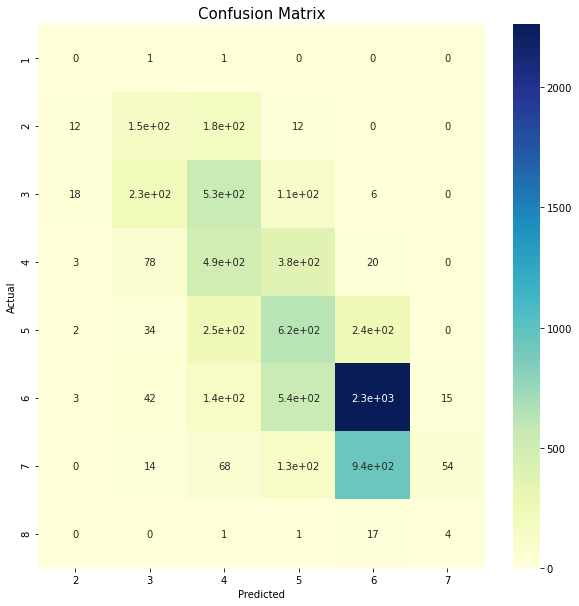

In [178]:
#Confusion matrix of predictions
confusion_matrix = pd.crosstab(df_test["rl class"], df_test["pred rl class"], rownames=['Actual'], colnames=['Predicted'])
plt.figure(figsize = (10,10))
sns.heatmap(confusion_matrix, annot=True, cmap="YlGnBu")
plt.title("Confusion Matrix", fontsize = 15)
plt.show()

In [179]:
mispredictions_df = df_test[df_test["rl class"] != df_test["pred rl class"]]
mispredictions_df.head()

,Unnamed: 0,utr,set,0,1,2,3,4,5,6,...,r11,r12,total,rl,len,one-hot encoding,scaled_rl,pred rl,rl class,pred rl class
0,30,CCTTCAATGATTACCTCTATCCCCA,random,291,448,539,529,527,338,170,...,0.059276,0.113321,0.001592,4.300281,25,"[[0, 1, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0,...",-0.743234,4.862675,4,5
5,45006,CAACGGCTTTTGTGCTTCCCTACCC,random,187,160,135,172,353,411,269,...,0.087781,0.067890,0.001235,5.895407,25,"[[0, 1, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [0,...",0.450943,5.493638,6,5
7,35995,ACGCTCCCGGATTCTTCTCCTTCCG,random,237,179,212,178,368,393,223,...,0.078903,0.083875,0.001213,5.466858,25,"[[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0,...",0.130113,5.505890,5,6
9,29999,CATACATTCTTGGCTCAACCATATG,random,189,172,166,154,290,380,235,...,0.086530,0.053736,0.001162,5.865569,25,"[[0, 1, 0, 0], [1, 0, 0, 0], [0, 0, 0, 1], [1,...",0.428605,5.383320,6,5
12,63021,CACACGCCGCTCCAGCCCATAATCT,random,247,228,332,269,351,316,164,...,0.066263,0.091499,0.001179,4.920480,25,"[[0, 1, 0, 0], [1, 0, 0, 0], [0, 1, 0, 0], [1,...",-0.278928,5.511337,5,6


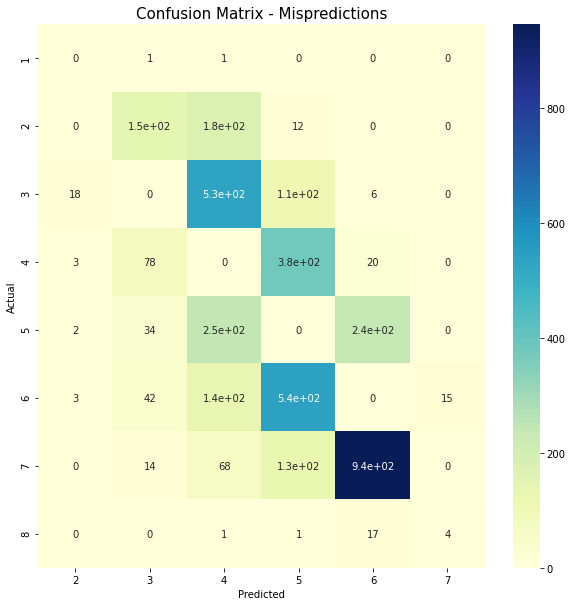

In [180]:
#Confusion matrix of predictions
confusion_matrix = pd.crosstab(mispredictions_df["rl class"], mispredictions_df["pred rl class"], rownames=['Actual'], colnames=['Predicted'])
plt.figure(figsize = (10,10))
sns.heatmap(confusion_matrix, annot=True, cmap="YlGnBu")
plt.title("Confusion Matrix - Mispredictions", fontsize = 15)
plt.show()

In [182]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

y_test = df_test["rl class"]
y_pred = df_test["pred rl class"]

print("Precision Score : ",precision_score(y_test, y_pred, 
                                           pos_label='positive',
                                           average='micro'))
print("Recall Score : ",recall_score(y_test, y_pred, 
                                           pos_label='positive',
                                           average='micro'))

Precision Score :  0.4826315789473684
Recall Score :  0.4826315789473684


/Users/mariehuynh/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1267: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn("Note that pos_label (set to %r) is ignored when "


## What if we try on scaled MRL ? Do we obtain better results ?

In [185]:
df_train.head()

,Unnamed: 0,utr,set,0,1,2,3,4,5,6,...,r8,r9,r10,r11,r12,total,rl,len,one-hot encoding,scaled_rl
100,84339,CCCAAACAATGACCATCTGACTCCGGTCAAGTT,random,251,306,327,299,313,199,81,...,0.039507,0.043015,0.047276,0.051164,0.132952,0.001017,4.146183,33,"[[0, 1, 0, 0], [0, 1, 0, 0], [0, 1, 0, 0], [1,...",-0.858599
101,9045,CCATATTTGAGTAAGCCACTCACATT,random,154,154,113,97,267,323,211,...,0.083512,0.083486,0.074304,0.078345,0.058800,0.000933,5.788789,26,"[[0, 1, 0, 0], [0, 1, 0, 0], [1, 0, 0, 0], [0,...",0.371124
102,75027,CATACCATATGCAAAGTCTATCTTG,random,188,162,198,204,345,309,142,...,0.056654,0.060465,0.068254,0.076314,0.092855,0.000970,5.137631,25,"[[0, 1, 0, 0], [1, 0, 0, 0], [0, 0, 0, 1], [1,...",-0.116360
103,92334,GCAAACCAAACTCACTACCCCTGACACC,human,172,107,86,76,172,260,185,...,0.112399,0.098983,0.092389,0.089096,0.047820,0.000895,6.232782,28,"[[0, 0, 1, 0], [0, 1, 0, 0], [1, 0, 0, 0], [1,...",0.703515
104,62996,GGAATGGCCTGCTTCGACTGTTCTT,random,437,876,528,272,125,76,37,...,0.023734,0.028215,0.038460,0.030416,0.053246,0.001079,2.816402,25,"[[0, 0, 1, 0], [0, 0, 1, 0], [1, 0, 0, 0], [1,...",-1.854128


In [186]:
y_train2 = df_train["scaled_rl"]

In [187]:
model2 = train_lstm_model(X_train, y_train2, nb_epoch=5)

/Users/mariehuynh/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/5
794/794 [==============================] - 259s 320ms/step - loss: 0.9474
Epoch 2/5
794/794 [==============================] - 263s 332ms/step - loss: 0.5716
Epoch 3/5
794/794 [==============================] - 458s 577ms/step - loss: 0.4959
Epoch 4/5
794/794 [==============================] - 272s 343ms/step - loss: 0.4785
Epoch 5/5
794/794 [==============================] - 221s 278ms/step - loss: 0.4679


In [188]:
preds2 = model.predict(X_test).reshape(-1)
preds2

array([4.862675 , 5.79163  , 5.5970836, ..., 6.273632 , 2.2081926,
       5.3504477], dtype=float32)

In [195]:
scaler = preprocessing.StandardScaler()
scaler.fit(df["rl"].values.reshape(-1,1))
final_preds2 = scaler.inverse_transform(preds2)

In [196]:
r = r2(df_test["scaled_rl"], final_preds2)
print('r-squared = ', r)

r-squared =  0.6178245353213535


/Users/mariehuynh/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


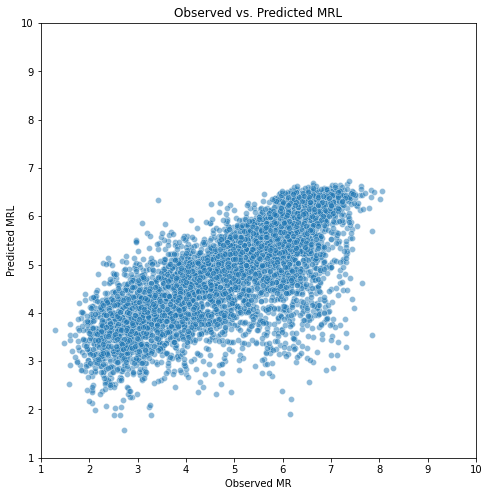

In [197]:
fig = plt.figure(figsize = (8,8))
sns.scatterplot(df_test['rl'], preds2,linewidth = 0.5, alpha=0.5)
plt.xlabel('Observed MR')
plt.ylabel('Predicted MRL') 
plt.xlim(1, 10)
plt.ylim(1, 10)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.title('Observed vs. Predicted MRL')
#plt.savefig("CNN1.pdf", bbox_inches = "tight")
plt.show()